In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Parameters 

In [206]:
args = {'lr':0.01,
        'batch_size':32,
        'main epochs':100,
        'pretrain epochs': 100,
        'noise':0.001,
        'train_size':0.5,
        }

# Prepare Data

In [207]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=0, noise_scale=args['noise'], tandem=1)

In [208]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [209]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [210]:
# temp in spec out
layers = []
class SubNN(nn.Module):
    def __init__(self, spec_size, temp_size):
        super(SubNN, self).__init__()
        self.lin1 = nn.Linear(temp_size, 7)
        self.lin2 = nn.Linear(7, 15)
        self.lin3 = nn.Linear(15, 30)
        self.lin4 = nn.Linear(30, 60)
        self.lin_fin = nn.Linear(60, spec_size)
        
        global layers 
        layers = [self.lin1, self.lin2, self.lin3, self.lin4, self.lin_fin]


    def forward(self, x):
        spec_pred = F.leaky_relu(self.lin1(x))
        spec_pred = F.leaky_relu(self.lin2(spec_pred))
        spec_pred = F.leaky_relu(self.lin3(spec_pred))
        spec_pred = F.leaky_relu(self.lin4(spec_pred))
        spec_pred = self.lin_fin(spec_pred)
        return spec_pred

In [211]:
# spec in spec out
class MainNN(nn.Module):
    def __init__(self, temp_size, spec_size):
        super(MainNN, self).__init__()
        self.subnet = SubNN(spec_size=spec_size, temp_size=temp_size) # temp in spec out
        self.lin1 = nn.Linear(spec_size, 45) 
        self.lin2 = nn.Linear(45, 45)
        self.lin3 = nn.Linear(45, 45)
        self.lin_fin = nn.Linear(45, temp_size)

    def forward(self, x):
        temp_pred = F.leaky_relu(self.lin1(x))
        temp_pred = F.leaky_relu(self.lin2(temp_pred))
        temp_pred = F.leaky_relu(self.lin3(temp_pred))
        temp_pred = self.lin_fin(temp_pred)
        
        spec_pred = self.subnet(temp_pred)

        return spec_pred, temp_pred

In [212]:
n_samples = len(train_dataset)
_, temp_size = dataset.x.shape
_, spec_size = dataset.y.shape

main_model = MainNN(temp_size=temp_size, spec_size=spec_size)
nested_model = SubNN(temp_size=temp_size, spec_size=spec_size)

# Construct Loss and Optimizer

In [213]:
learning_rate = args['lr']
criterion = nn.L1Loss()
main_optimizer = torch.optim.RAdam(main_model.parameters(), lr=learning_rate)
nested_optimizer = torch.optim.Rprop(nested_model.parameters(), lr=learning_rate)

# Training Loop

In [214]:
# pretrain loop
num_epochs = args['pretrain epochs']
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:
        # empty gradients
        nested_optimizer.zero_grad()
        
        # forward pass and loss
        spec_pred = nested_model(temp_batch)
        loss = criterion(spec_pred, spec_batch)

        # backward pass
        loss.backward()

        # update
        nested_optimizer.step()


    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')

print(f'\nbest loss: {best_loss} in epoch: {best_epoch}')

epoch: 10, loss = 0.32450956106185913
epoch: 20, loss = 0.15906083583831787
epoch: 30, loss = 0.26060184836387634
epoch: 40, loss = 0.3674890100955963
epoch: 50, loss = 0.24040332436561584
epoch: 60, loss = 0.22746235132217407
epoch: 70, loss = 0.2042027860879898
epoch: 80, loss = 0.21714642643928528
epoch: 90, loss = 0.2719047963619232
epoch: 100, loss = 0.29962319135665894

best loss: 0.15906083583831787 in epoch: 20


In [215]:
# freeze weights
for layer in layers:
    for param in layer.parameters():
        param.requires_grad = False

In [216]:
# main loop
num_epochs = args['main epochs']
loss_list = []
temp_loss_list = []
spec_loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:        
        # empty gradients
        main_optimizer.zero_grad()

        # forward pass and loss
        spec_pred, temp_pred = main_model(spec_batch)

        # get loss
        spec_loss = criterion(spec_pred, spec_batch)
        temp_loss = criterion(temp_pred, temp_batch)
        total_loss = spec_loss + temp_loss

        # backward pass
        total_loss.backward()

        # update
        main_optimizer.step()

        

    loss_list.append(temp_loss.item())
    spec_loss_list.append(spec_loss.item())
    temp_loss_list.append(temp_loss.item())

    if temp_loss < best_loss:
        best_loss = temp_loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, spectrum loss = {spec_loss:.6f}, temperature loss = {temp_loss:.6f}')

print(f'\nbest temperature loss: {best_loss:.3f} in epoch: {best_epoch}')

epoch: 10, spectrum loss = 0.398203, temperature loss = 49.663708
epoch: 20, spectrum loss = 0.868150, temperature loss = 10.033819
epoch: 30, spectrum loss = 0.263606, temperature loss = 9.935307
epoch: 40, spectrum loss = 0.151706, temperature loss = 22.305967
epoch: 50, spectrum loss = 0.124961, temperature loss = 12.091751
epoch: 60, spectrum loss = 0.107863, temperature loss = 10.557403
epoch: 70, spectrum loss = 0.114237, temperature loss = 10.230740
epoch: 80, spectrum loss = 0.097689, temperature loss = 10.131455
epoch: 90, spectrum loss = 0.065650, temperature loss = 17.691677
epoch: 100, spectrum loss = 0.224769, temperature loss = 11.565678

best temperature loss: 7.218 in epoch: 68


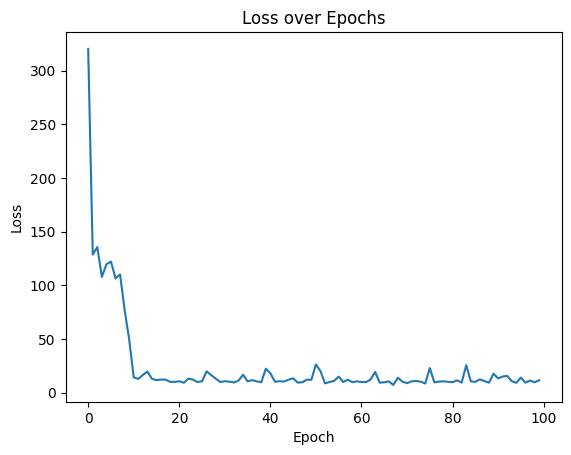

In [217]:
plt.plot(loss_list, label='total loss')
#plt.plot(spec_loss_list[20:], label='spectrum loss')
#plt.plot(temp_loss_list[10:50], label='temperature loss')

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [218]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index, prediction):
    actual_np = actual[index]
    pred_np = pred[index]

    if prediction == 'spec':
        plt.title("Thermel-Emission Spectrum")
        plt.xlabel("Wavlength (m)")
        plt.ylabel("Intensity")
        pred_np = pred_np * (10**-12)
        actual_np = actual_np * (10**-12)
        wavelengths = dataset.wavelengths * (10**-3)
        plt.plot(wavelengths, actual_np, label='actual')
        plt.plot(wavelengths, pred_np, 'r+', label='predicted')
    else:
        plt.title("Temperature Distribution")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")
        x = np.arange(1, 12, 1)
        plt.plot(x, actual_np, label='actual')
        plt.plot(x, pred_np, 'r+', label='predicted')
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    

    plt.legend()
    plt.show()

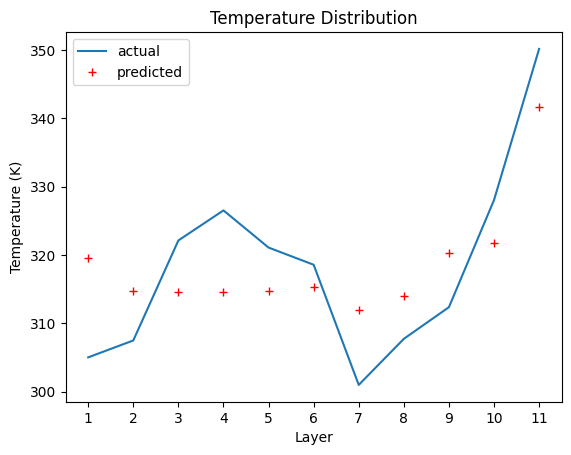

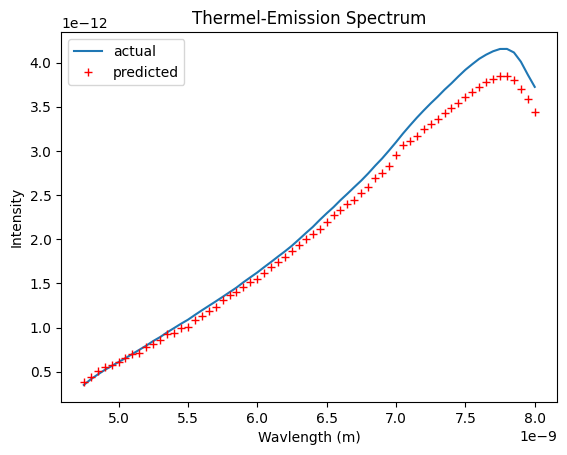

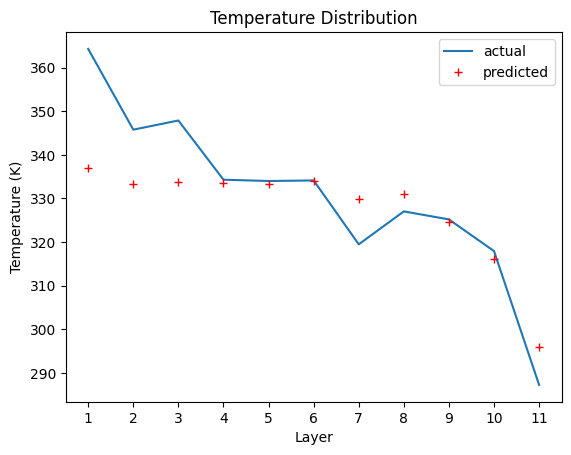

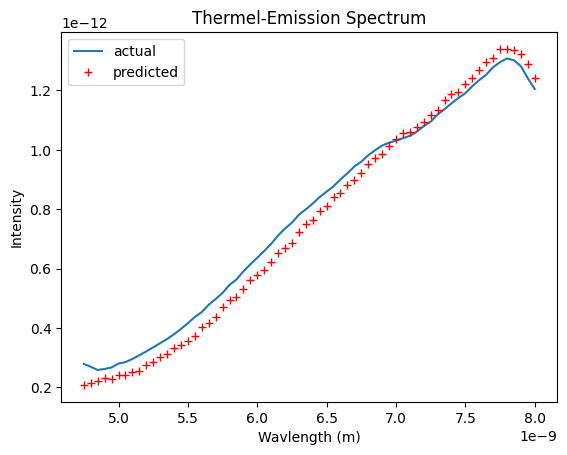

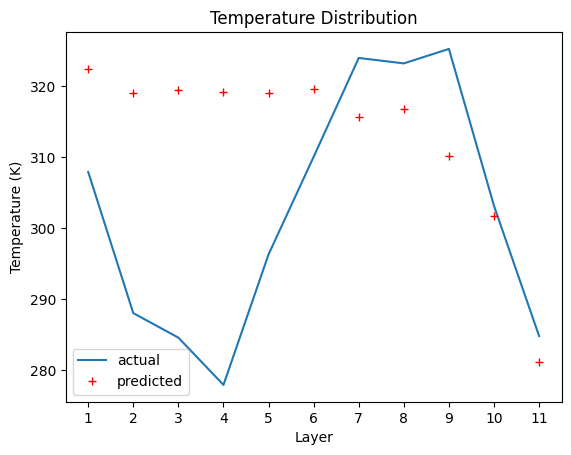

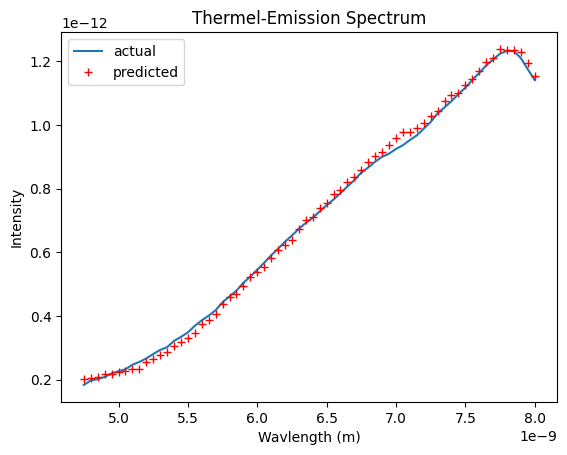

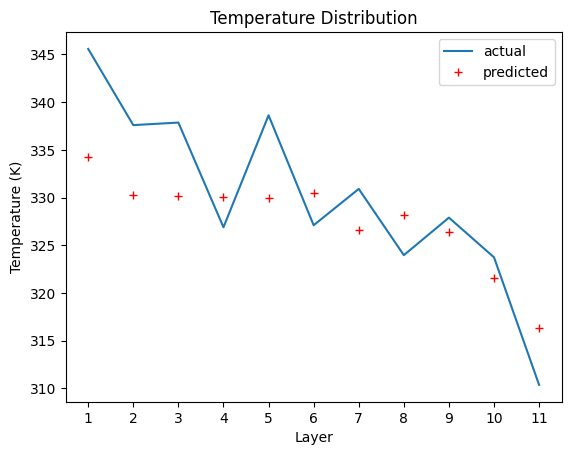

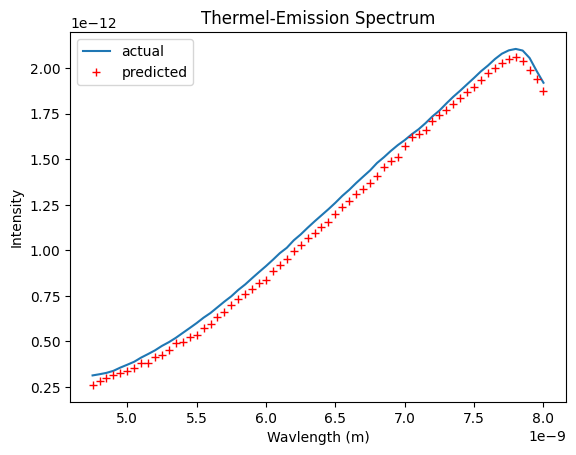

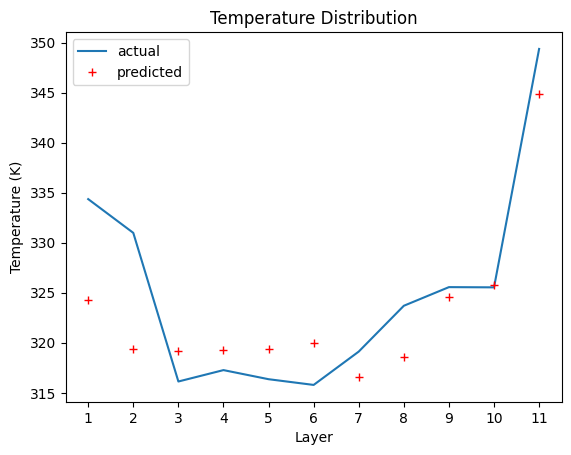

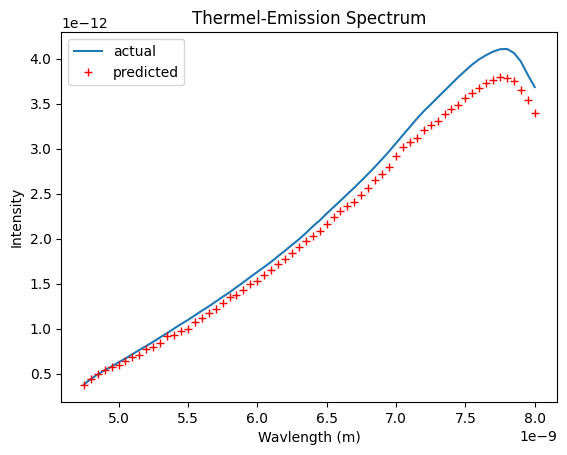

average temperature loss: 9.538
average spectrum loss: 0.127657


In [219]:
total_temp_loss = 0
total_spec_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0


with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        spec_pred, temp_pred = main_model(spec_batch)
        
        temp_loss = criterion(temp_pred, temp_batch)
        total_temp_loss += temp_loss.item() * len(temp_batch)

        spec_loss = criterion(spec_pred, spec_batch)
        total_spec_loss += spec_loss.item() * len(spec_batch)

        n_samples += len(temp_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(temp_pred.numpy(), temp_batch.numpy(), 0, prediction='temp') 
            plot_actual_vs_pred(spec_pred.numpy(), spec_batch.numpy(), 0, prediction='spec')

average_temp_loss = total_temp_loss/n_samples
average_spec_loss = total_spec_loss/n_samples
print(f"average temperature loss: {average_temp_loss:.3f}\naverage spectrum loss: {average_spec_loss:.6f}")